In [1]:
import os
import cv2
import time
import numpy as np
import xml.etree.ElementTree as Et

# from pascal_voc_writer import Writer
from PIL import Image
from PIL import ImageDraw
from pascal_voc_writer import Writer
import copy

In [2]:
dataset_path = '/media/data2/dataset/SSDD/256/Train_dt/'
window = 148

In [3]:
def load_xml(xml_path, draw):
    xml = open(xml_path, "r")
    tree = Et.parse(xml)
    root = tree.getroot()

    bounding_box =[]

    objects = root.findall("object")
    print("Objects Description")
    for _object in objects:
        name = _object.find("name").text
        bndbox = _object.find("bndbox")
        xmin = int(bndbox.find("xmin").text)
        ymin = int(bndbox.find("ymin").text)
        xmax = int(bndbox.find("xmax").text)
        ymax = int(bndbox.find("ymax").text)

        object_box = [(int(xmin), int(ymin)), (int(xmax), int(ymax)), name]

        bounding_box.append(object_box)

        draw.rectangle(((xmin, ymin), (xmax, ymax)), outline="red")

    return bounding_box


def sliding_window(image, stepSize, windowSize):
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            # yield the current window
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])


def make_new_xml(new_img_dir, rectangle, box_list, cropped_xml_name):
    writer = Writer(new_img_dir, 148, 148)
    
    for box in box_list:
        new_xmin = box[0][0] - rectangle[0][0]
        new_ymin = box[0][1] - rectangle[0][1]
        new_xmax = new_xmin + box[1][0] - box[0][0]
        new_ymax = new_ymin + box[1][1] - box[0][1]
        writer.addObject(box[2], new_xmin, new_ymin, new_xmax, new_ymax)
    cropped_xml_name = cropped_xml_name + ".xml"
    writer.save(os.path.join(xml_save_dir, cropped_xml_name))
    # 저장 경로 수정!


def slice_image(image_dir, xml_dir, image_list):
    (winW, winH) = (148, 148)

    for i in image_list:
        # image path
        i_path = os.path.join(image_dir, i)
        # find the annotation file using image name
        xml_file = ann_list[ann_list.index(".".join([i.split(".")[0], "xml"]))]

        pil_image = Image.open(i_path)
        draw = ImageDraw.Draw(pil_image)

        # draw bounding boxes from xml file
        bounding_box = load_xml(os.path.join(xml_dir, xml_file), draw)

        # convert PIL image to cv2 image
        image = np.array(pil_image)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        # load the image and define the window width and height
        # image = cv2.imread(i_path)
        id = 0

        for (x, y, window) in sliding_window(image, stepSize=args["step"], windowSize=(winW, winH)):
            # if the window does not meet our desired window size, ignore it
            if window.shape[0] != winH or window.shape[1] != winW:
                continue

            # THIS IS WHERE YOU WOULD PROCESS YOUR WINDOW, SUCH AS APPLYING A
            # MACHINE LEARNING CLASSIFIER TO CLASSIFY THE CONTENTS OF THE
            # WINDOW

            # since we do not have a classifier, we'll just draw the window
            clone = image.copy()
            cv2.rectangle(clone, (x, y), (x + winW, y + winH), (0, 255, 0), 2)

            rectangle = [(x, y), (x + winW, y + winH)]
            print(rectangle)

            # if bounding_box is in sliding window, save image
            for box in bounding_box:
                if (box[0][0] >= rectangle[0][0])\
                        and (box[0][1] >= rectangle[0][1])\
                        and (box[1][0] <= rectangle[1][0])\
                        and (box[1][1] <= rectangle[1][1]):

                    clone2 = image.copy()
                    cropped_image = clone2[x:(x + winW), y:(y + winH)]
                    id += 1

                    cropped_img_name = i.split(".")[0] + "_" + str(id)
                    cropped_img_dir = os.path.join(img_save_dir, (cropped_img_name + ".jpg"))
                    cv2.imwrite(cropped_img_dir, cropped_image)
                    print("New image saved!")

                    # make new xml file for sliced image
                    make_new_xml(cropped_img_dir, rectangle, box, cropped_img_name)
                    print("New Annotation saved!")

            cv2.imshow("Window", clone)
            cv2.waitKey(1)
            time.sleep(0.1)
            ###### deleted saving. Need to work on that again ######

In [4]:
# img_save_dir = '/media/data2/dataset/SSDD/256/Train_dt/148'

In [5]:
IMAGE_FOLDER = "img"
ANNOTATIONS_FOLDER = "label"

ann_dir, ann_flist, ann_list = next(os.walk(os.path.join(dataset_path, ANNOTATIONS_FOLDER)))
img_dir, img_flist, img_list = next(os.walk(os.path.join(dataset_path, IMAGE_FOLDER)))

save_dir = os.path.join(dataset_path, str(148))
img_save_dir = os.path.join(save_dir, IMAGE_FOLDER)
xml_save_dir = os.path.join(save_dir, ANNOTATIONS_FOLDER)

In [34]:
img_list[1]

'ship02017013101056014.jpg'

In [32]:
i_path = os.path.join(img_dir, img_list[1])
xml_file = ann_list[ann_list.index(".".join([img_list[1].split(".")[0], "xml"]))]
pil_image = Image.open(i_path)
draw = ImageDraw.Draw(pil_image)
image = np.array(pil_image)

# draw bounding boxes from xml file
bounding_box = load_xml(os.path.join(ann_dir, xml_file), draw)

Objects Description


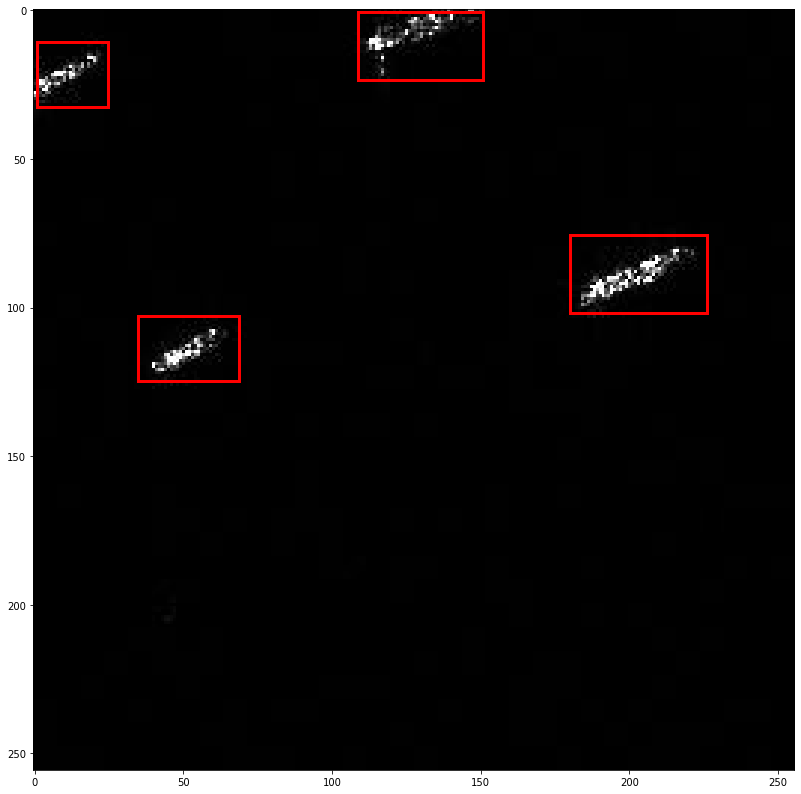

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize = (14,14))
plt.imshow(pil_image)

In [6]:
winW, winH = 148, 148
id_num = 0

In [7]:
for i in img_list:
    i_path = os.path.join(img_dir, i)
    xml_file = ann_list[ann_list.index(".".join([i.split(".")[0], "xml"]))]
    pil_image = Image.open(i_path)
    draw = ImageDraw.Draw(pil_image)
    image = np.array(pil_image)
    # draw bounding boxes from xml file
    bounding_box = load_xml(os.path.join(ann_dir, xml_file), draw)
    for (x, y, window) in sliding_window(image, stepSize=108, windowSize=(148, 148)):
        # if the window does not meet our desired window size, ignore it
        if window.shape[0] != 148 or window.shape[1] != 148:
            continue
            
        # since we do not have a classifier, we'll just draw the window
        clone = image.copy()
        cv2.rectangle(clone, (x, y), (x + winW, y + winH), (0, 255, 0), 2)

        rectangle = [(x, y), (x + winW, y + winH)]
        # if bounding_box is in sliding window, save image
        box_list = []
        for box in bounding_box:
            if (box[0][0] >= rectangle[0][0])\
                    and (box[0][1] >= rectangle[0][1])\
                    and (box[1][0] <= rectangle[1][0])\
                    and (box[1][1] <= rectangle[1][1]):
                box_list.append(box)
        
        if is_train:
            if len(box_list) > 0:
                cropped_image = window
                id_num += 1
                cropped_img_name = i.split(".")[0] + "_" + str(id_num)
                cropped_img_dir = os.path.join(img_save_dir, (cropped_img_name + ".jpg"))
                make_new_xml(cropped_img_dir, rectangle, box_list, cropped_img_name)
                print("New Annotation saved!")
                crop_image = Image.fromarray(cropped_image)
                crop_image.save(cropped_img_dir)
                print("New image saved!")
        else:
            cropped_image = window
            id_num += 1
            cropped_img_name = i.split(".")[0] + "_" + str(id_num)
            cropped_img_dir = os.path.join(img_save_dir, (cropped_img_name + ".jpg"))
            make_new_xml(cropped_img_dir, rectangle, box_list, cropped_img_name)
            print("New Annotation saved!")
            crop_image = Image.fromarray(cropped_image)
            crop_image.save(cropped_img_dir)
            print("New image saved!")

Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!


New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New

New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!


New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!


New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Obj

New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New A

New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Obj

New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Obj

New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!


New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!


New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New

New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New

New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!


New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!


New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New

New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New A

New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New A

New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New

New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New

New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Obj

New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!


New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!


New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Obj

New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Obj

New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Obj

New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New

New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New A

New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New

New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Obj

New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!


New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!


New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New

New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New A

New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New

New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New A

New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Obj

New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New

New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New A

New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!


New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New

New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New A

New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New A

New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!


New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New A

New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!


New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Obj

Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!


New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!


New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New

New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New A

New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!


New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New

New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New

New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Obj

New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New

New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Obj

New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!


New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Obj

New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Obj

New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New

New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Obj

New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New A

New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Objects Description
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
New Annotation saved!
New image saved!
Obj

ValueError: 'Thumbs.xml' is not in list

In [11]:
cropped_img_dir

'/media/data2/dataset/SSDD/256/Train_dt/148/img/ship02016101501046033_1.jpg'

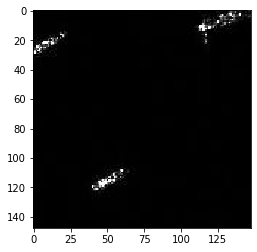

In [67]:
plt.imshow(window)

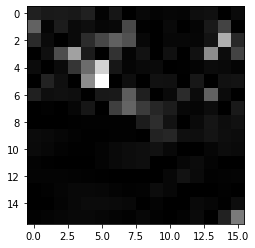

In [13]:
plt.imshow(window)

In [13]:
IMAGE_FOLDER = "img"
ANNOTATIONS_FOLDER = "label"

ann_dir, ann_flist, ann_list = next(os.walk(os.path.join(dataset_path, ANNOTATIONS_FOLDER)))
img_dir, img_flist, img_list = next(os.walk(os.path.join(dataset_path, IMAGE_FOLDER)))

# make a new directory to save preprocessed data
save_dir = os.path.join(dataset_path, '148')
img_save_dir = os.path.join(save_dir, IMAGE_FOLDER)
xml_save_dir = os.path.join(save_dir, ANNOTATIONS_FOLDER)

if not(os.path.isdir(save_dir)):
    os.makedirs(save_dir)
if not(os.path.isdir(img_save_dir)):
    os.makedirs(img_save_dir)
if not(os.path.isdir(xml_save_dir)):
    os.makedirs(xml_save_dir)

slice_image(img_dir, ann_dir, img_list)

NameError: name 'slice_image' is not defined

'/media/data2/dataset/SSDD/256/Train_dt/label'